In [1]:
import pandas as pd

In [2]:
import  lightgbm as lgb

In [3]:
df_train = pd.read_csv('C:/Users/PriyaN/Downloads/Demand-Forecasting sample data/Demand-Forecasting/train.csv')
df_test = pd.read_csv('C:/Users/PriyaN/Downloads/Demand-Forecasting sample data/Demand-Forecasting/test.csv')
import seaborn as sns
df_train

sns.lineplot(x="date", y="sales",legend = 'full' , data=df_train)

In [4]:
print(df_train.head(3))
print(df_test.head(3))

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
   id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1


In [5]:
def add_new_features(x):
    x['date'] = pd.to_datetime(x['date'])
    x['year'] = x.date.dt.year
    x['month'] = x.date.dt.month
    x['dayofweek'] = x.date.dt.dayofweek
    return x

In [6]:
df_train = add_new_features(df_train)
df_test= add_new_features(df_test)

In [7]:

df_train

,date,store,item,sales,year,month,dayofweek
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5
...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,2
912996,2017-12-28,10,50,59,2017,12,3
912997,2017-12-29,10,50,74,2017,12,4
912998,2017-12-30,10,50,62,2017,12,5


In [8]:
df_train['daily_avg']=df_train.groupby(['item','store','dayofweek'])['sales'].transform('mean')
df_train['monthly_avg']=df_train.groupby(['item','store','month'])['sales'].transform('mean')

In [9]:
daily_avg=df_train.groupby(['item','store','dayofweek'])['sales'].mean().reset_index()
monthly_avg=df_train.groupby(['item','store','month'])['sales'].mean().reset_index()

In [10]:
monthly_avg

,item,store,month,sales
0,1,1,1,13.709677
1,1,1,2,14.631206
2,1,1,3,17.600000
3,1,1,4,20.786667
4,1,1,5,22.245161
...,...,...,...,...
5995,50,10,8,84.567742
5996,50,10,9,78.873333
5997,50,10,10,73.045161
5998,50,10,11,76.993333


In [11]:
def merge(x,y,col,col_name):
    x =pd.merge(x, y, how='left', on=None, left_on=col, right_on=col,
            left_index=False, right_index=False, sort=True,
             copy=True, indicator=False,validate=None)
    
    x=x.rename(columns={'sales':col_name})
    return x

df_test=merge(df_test, daily_avg,['item','store','dayofweek'],'daily_avg')
df_test=merge(df_test, monthly_avg,['item','store','month'],'monthly_avg')

In [12]:
print(df_test.columns)
print(df_train.columns)

Index(['id', 'date', 'store', 'item', 'year', 'month', 'dayofweek',
       'daily_avg', 'monthly_avg'],
      dtype='object')
Index(['date', 'store', 'item', 'sales', 'year', 'month', 'dayofweek',
       'daily_avg', 'monthly_avg'],
      dtype='object')


In [13]:
df_test=df_test.drop(['id'],axis=1)
df_train=df_train.drop(['date'],axis=1)
df_test=df_test.drop(['date'],axis=1)


In [14]:
df_test.columns

Index(['store', 'item', 'year', 'month', 'dayofweek', 'daily_avg',
       'monthly_avg'],
      dtype='object')

In [15]:
y=pd.DataFrame()
y=df_train['sales']

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split


In [17]:
x_train,x_test,y_train,y_test = train_test_split(df_train.drop('sales',axis=1),df_train.pop('sales'),random_state=123,test_size=0.2)

In [18]:
def XGBmodel(x_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params={'objective':'reg:linear','eval_metric':'mae'}
                    ,dtrain=matrix_train,num_boost_round=500, 
                    early_stopping_rounds=20,evals=[(matrix_test,'test')],)
    return model

model=XGBmodel(x_train,x_test,y_train,y_test)

C:\Users\PriyaN\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:53:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-mae:36.3051
Will train until test-mae hasn't improved in 20 rounds.
[1]	test-mae:25.4362
[2]	test-mae:17.8989
[3]	test-mae:12.8191
[4]	test-mae:9.59585
[5]	test-mae:7.71342
[6]	test-mae:6.6857
[7]	test-mae:6.14732
[8]	test-mae:5.8761
[9]	test-mae:5.74032
[10]	test-mae:5.67089
[11]	test-mae:5.63592
[12]	test-mae:5.61763
[13]	test-mae:5.60841
[14]	test-mae:5.60202
[15]	test-mae:5.59881
[16]	test-mae:5.59624
[17]	test-mae:5.59331
[18]	test-mae:5.59243
[19]	test-mae:5.59148
[20]	test-mae:5.5905
[21]	test-mae:5.58969
[22]	test-mae:5.58963
[23]	test-mae:5.58931
[24]	test-mae:5.58861
[25]	test-mae:5.58766
[26]	test-mae:5.58744
[27]	test-mae:5.58648
[28]	test-mae:5.5863
[29]	test-mae:5.58638
[30]	test-mae:5.58628
[31]	test-mae:5.58616
[32]	test-mae:5.58602
[33]	test-mae:5.58533
[34]	test-mae:5.58535
[35]	test-mae:5.58516
[3

In [19]:
df_test

,store,item,year,month,dayofweek,daily_avg,monthly_avg
0,1,1,2018,1,0,15.584615,13.709677
1,1,1,2018,1,0,15.584615,13.709677
2,1,1,2018,1,0,15.584615,13.709677
3,1,1,2018,1,0,15.584615,13.709677
4,1,1,2018,1,0,15.584615,13.709677
...,...,...,...,...,...,...,...
44995,10,50,2018,3,5,82.854406,67.780645
44996,10,50,2018,3,6,87.984674,67.780645
44997,10,50,2018,3,6,87.984674,67.780645
44998,10,50,2018,3,6,87.984674,67.780645


In [20]:
df_test1 = pd.read_csv('C:/Users/PriyaN/Downloads/Demand-Forecasting sample data/Demand-Forecasting/test.csv')
submission = pd.DataFrame(df_test1.pop('id'))
y_pred = model.predict(xgb.DMatrix(df_test), ntree_limit = model.best_ntree_limit)

submission['sales']= y_pred

submission.to_csv('submissionxgb.csv',index=False)

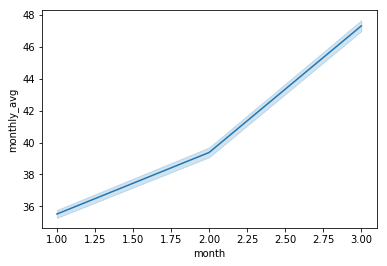

In [21]:
import seaborn as sns
sns.lineplot(x="month", y="monthly_avg",legend = 'full' , data=df_test)

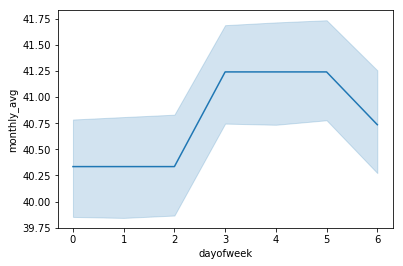

In [22]:
import seaborn as sns
sns.lineplot(x="dayofweek", y="monthly_avg",legend = 'full' , data=df_test)

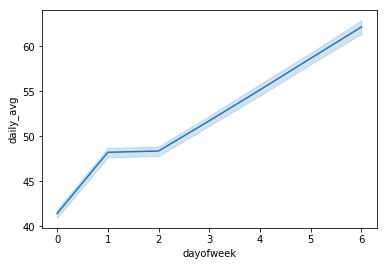

In [23]:
import seaborn as sns
sns.lineplot(x="dayofweek", y="daily_avg",legend = 'full' , data=df_test)